In [1]:
#IMPORT LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB, BernoulliNB
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from pycaret.classification import create_model


In [2]:
df=pd.read_csv('health care diabetes.csv')

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### Pregnancies: Number of times pregnant.
#### Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
#### BloodPressure: Diastolic blood pressure (mm Hg).
#### SkinThickness: Triceps skin fold thickness (mm).
####  Insulin: 2-Hour serum insulin (mu U/ml).
####  BMI: Body mass index (weight in kg/(height in m)^2).
####  DiabetesPedigreeFunction
####  Age: Age (years).
####  Outcome: '1' denotes patient having diabetes and '0' denotes patient not having diabetes.

In [4]:
df.describe('')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### The minimum value is 0 for glucose, bloodpressure, skinthickness, insulin ,BMI which is not medically possible and it shows a missing or incorrect data.

In [5]:
(df==0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

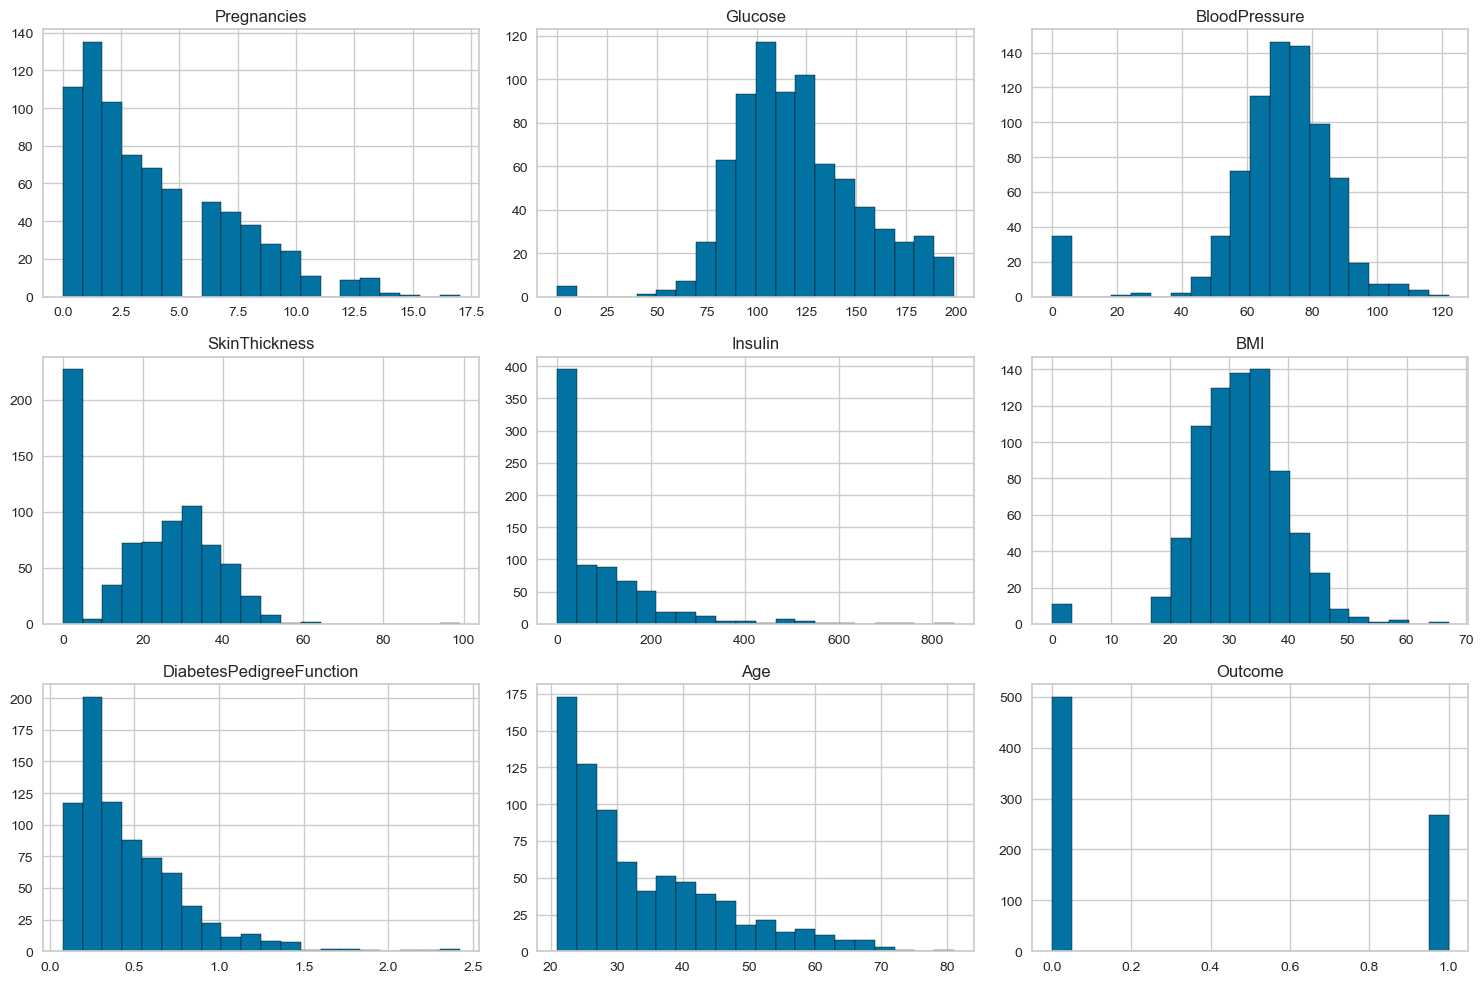

In [6]:
# Define the columns for which you want to create subplots
columns_to_plot = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Flatten the axes array to easily access individual subplots
axes = axes.flatten()

# Plot each column in a separate subplot
for i, column in enumerate(columns_to_plot):
    axes[i].hist(df[column], bins=20, edgecolor='black')
    axes[i].set_title(column)

# Adjust layout for better visibility
plt.tight_layout()

# Show the subplots
plt.show()


In [7]:
impossible_values = (df["Glucose"] == 0) | (df["BloodPressure"] == 0) | (df["SkinThickness"] == 0) | (df["Insulin"] == 0)| (df["BMI"] == 0)
impossible_values.sum()

376

In [8]:
zero_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = len(df)

for feature in zero_features:
    zero_count = df[df[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, percent is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Pregnancies 0 number of cases 111, percent is 14.45 %
Glucose 0 number of cases 5, percent is 0.65 %
BloodPressure 0 number of cases 35, percent is 4.56 %
SkinThickness 0 number of cases 227, percent is 29.56 %
Insulin 0 number of cases 374, percent is 48.70 %
BMI 0 number of cases 11, percent is 1.43 %


#### The result shows that ratio of value of zero in insulin and skinthickness  features seems to be high. that they have been recorded by mistake or they are missing values 
#### Fill  zeros with median of dataset. (because data is not normally diributed)
#### first we replace 0 with NAN or not a value and then replace nan with median.

In [9]:
lst=['SkinThickness','Insulin']
for i in lst:
    df[i].replace(0, np.nan, inplace=True)
    df[i].fillna(df[i].median(), inplace=True)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35.0,125.0,33.6,0.627,50,1
1,1,85,66,29.0,125.0,26.6,0.351,31,0
2,8,183,64,29.0,125.0,23.3,0.672,32,1
3,1,89,66,23.0,94.0,28.1,0.167,21,0
4,0,137,40,35.0,168.0,43.1,2.288,33,1


In [10]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [11]:
df.duplicated().sum()

0

In [12]:
#### check the outliers by plotting boxplot. 

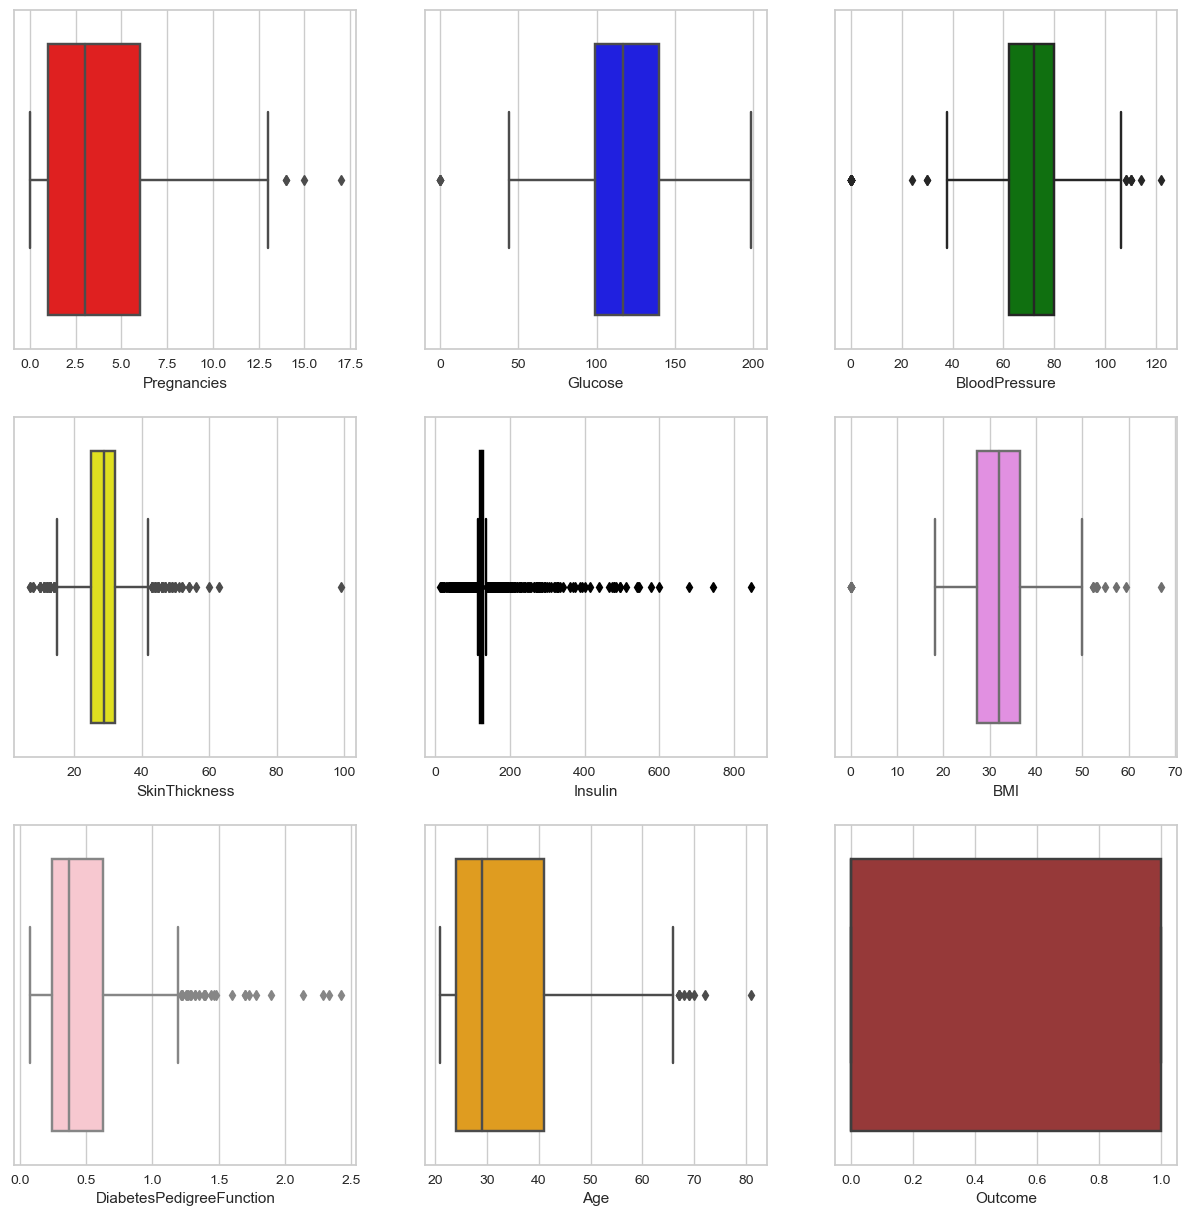

In [13]:
columns_to_plot = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
col_color=['red', 'blue','green', 'yellow','black', 'violet', 'pink','orange', 'brown']
fig,axes=plt.subplots(3,3 ,figsize=(15,15))
axes=axes.flatten()
for i,j, k in zip(axes,columns_to_plot,col_color):
    sns.boxplot(data=df, color=k, x=j, ax=i)
plt.show()           

    
    

#### removing outliers using trimming approach

In [14]:
 q1=df.quantile(0.25)
 q3=df.quantile(0.75)
 IQR= q3-q1
 upper_limit=q3+IQR*1.5
 lower_limit=q1-IQR*15
 print(f'upper_limit\n{upper_limit}')

 print('--------------------------------')

 print(f'lower_limit\n{lower_limit}')
 df= df[~((df < lower_limit) | (df > upper_limit)).any(axis=1)]

upper_limit
Pregnancies                  13.500
Glucose                     202.125
BloodPressure               107.000
SkinThickness                42.500
Insulin                     135.875
BMI                          50.550
DiabetesPedigreeFunction      1.200
Age                          66.500
Outcome                       2.500
dtype: float64
--------------------------------
lower_limit
Pregnancies                 -74.00000
Glucose                    -519.75000
BloodPressure              -208.00000
SkinThickness               -80.00000
Insulin                      35.25000
BMI                        -112.20000
DiabetesPedigreeFunction     -5.49375
Age                        -231.00000
Outcome                     -15.00000
dtype: float64


#### Heatmap

#### we wanna check the relationships between the different variables(columns). This can provide insights into which variables are strongly or weakly associated with each other.

<AxesSubplot:>

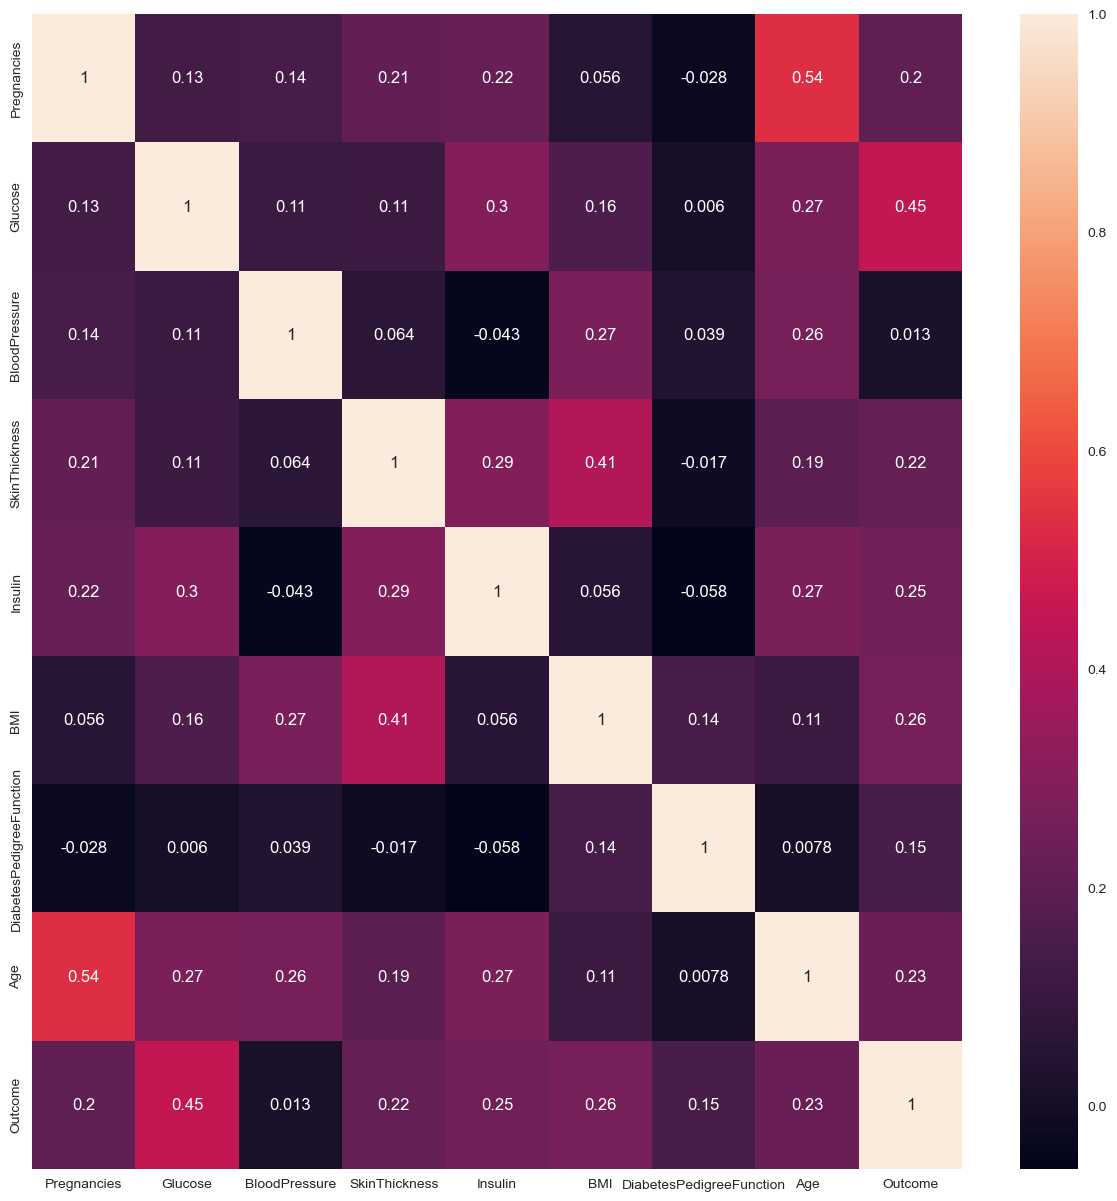

In [15]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True)

##### The correlation between Outcome and Glucose is high. Glucoe seems to be the most important feature in model training.BMI, Insulin, and Age are also expected to be used as important features in model training.
##### High correlation coefficient with SkinThickness and BMI. There may be a multicollinearity problem, but if there is a performance problem after checking the result, check it again.

In [16]:
### To understand pairwise relationships we use pair plots

<Figure size 1500x1000 with 0 Axes>

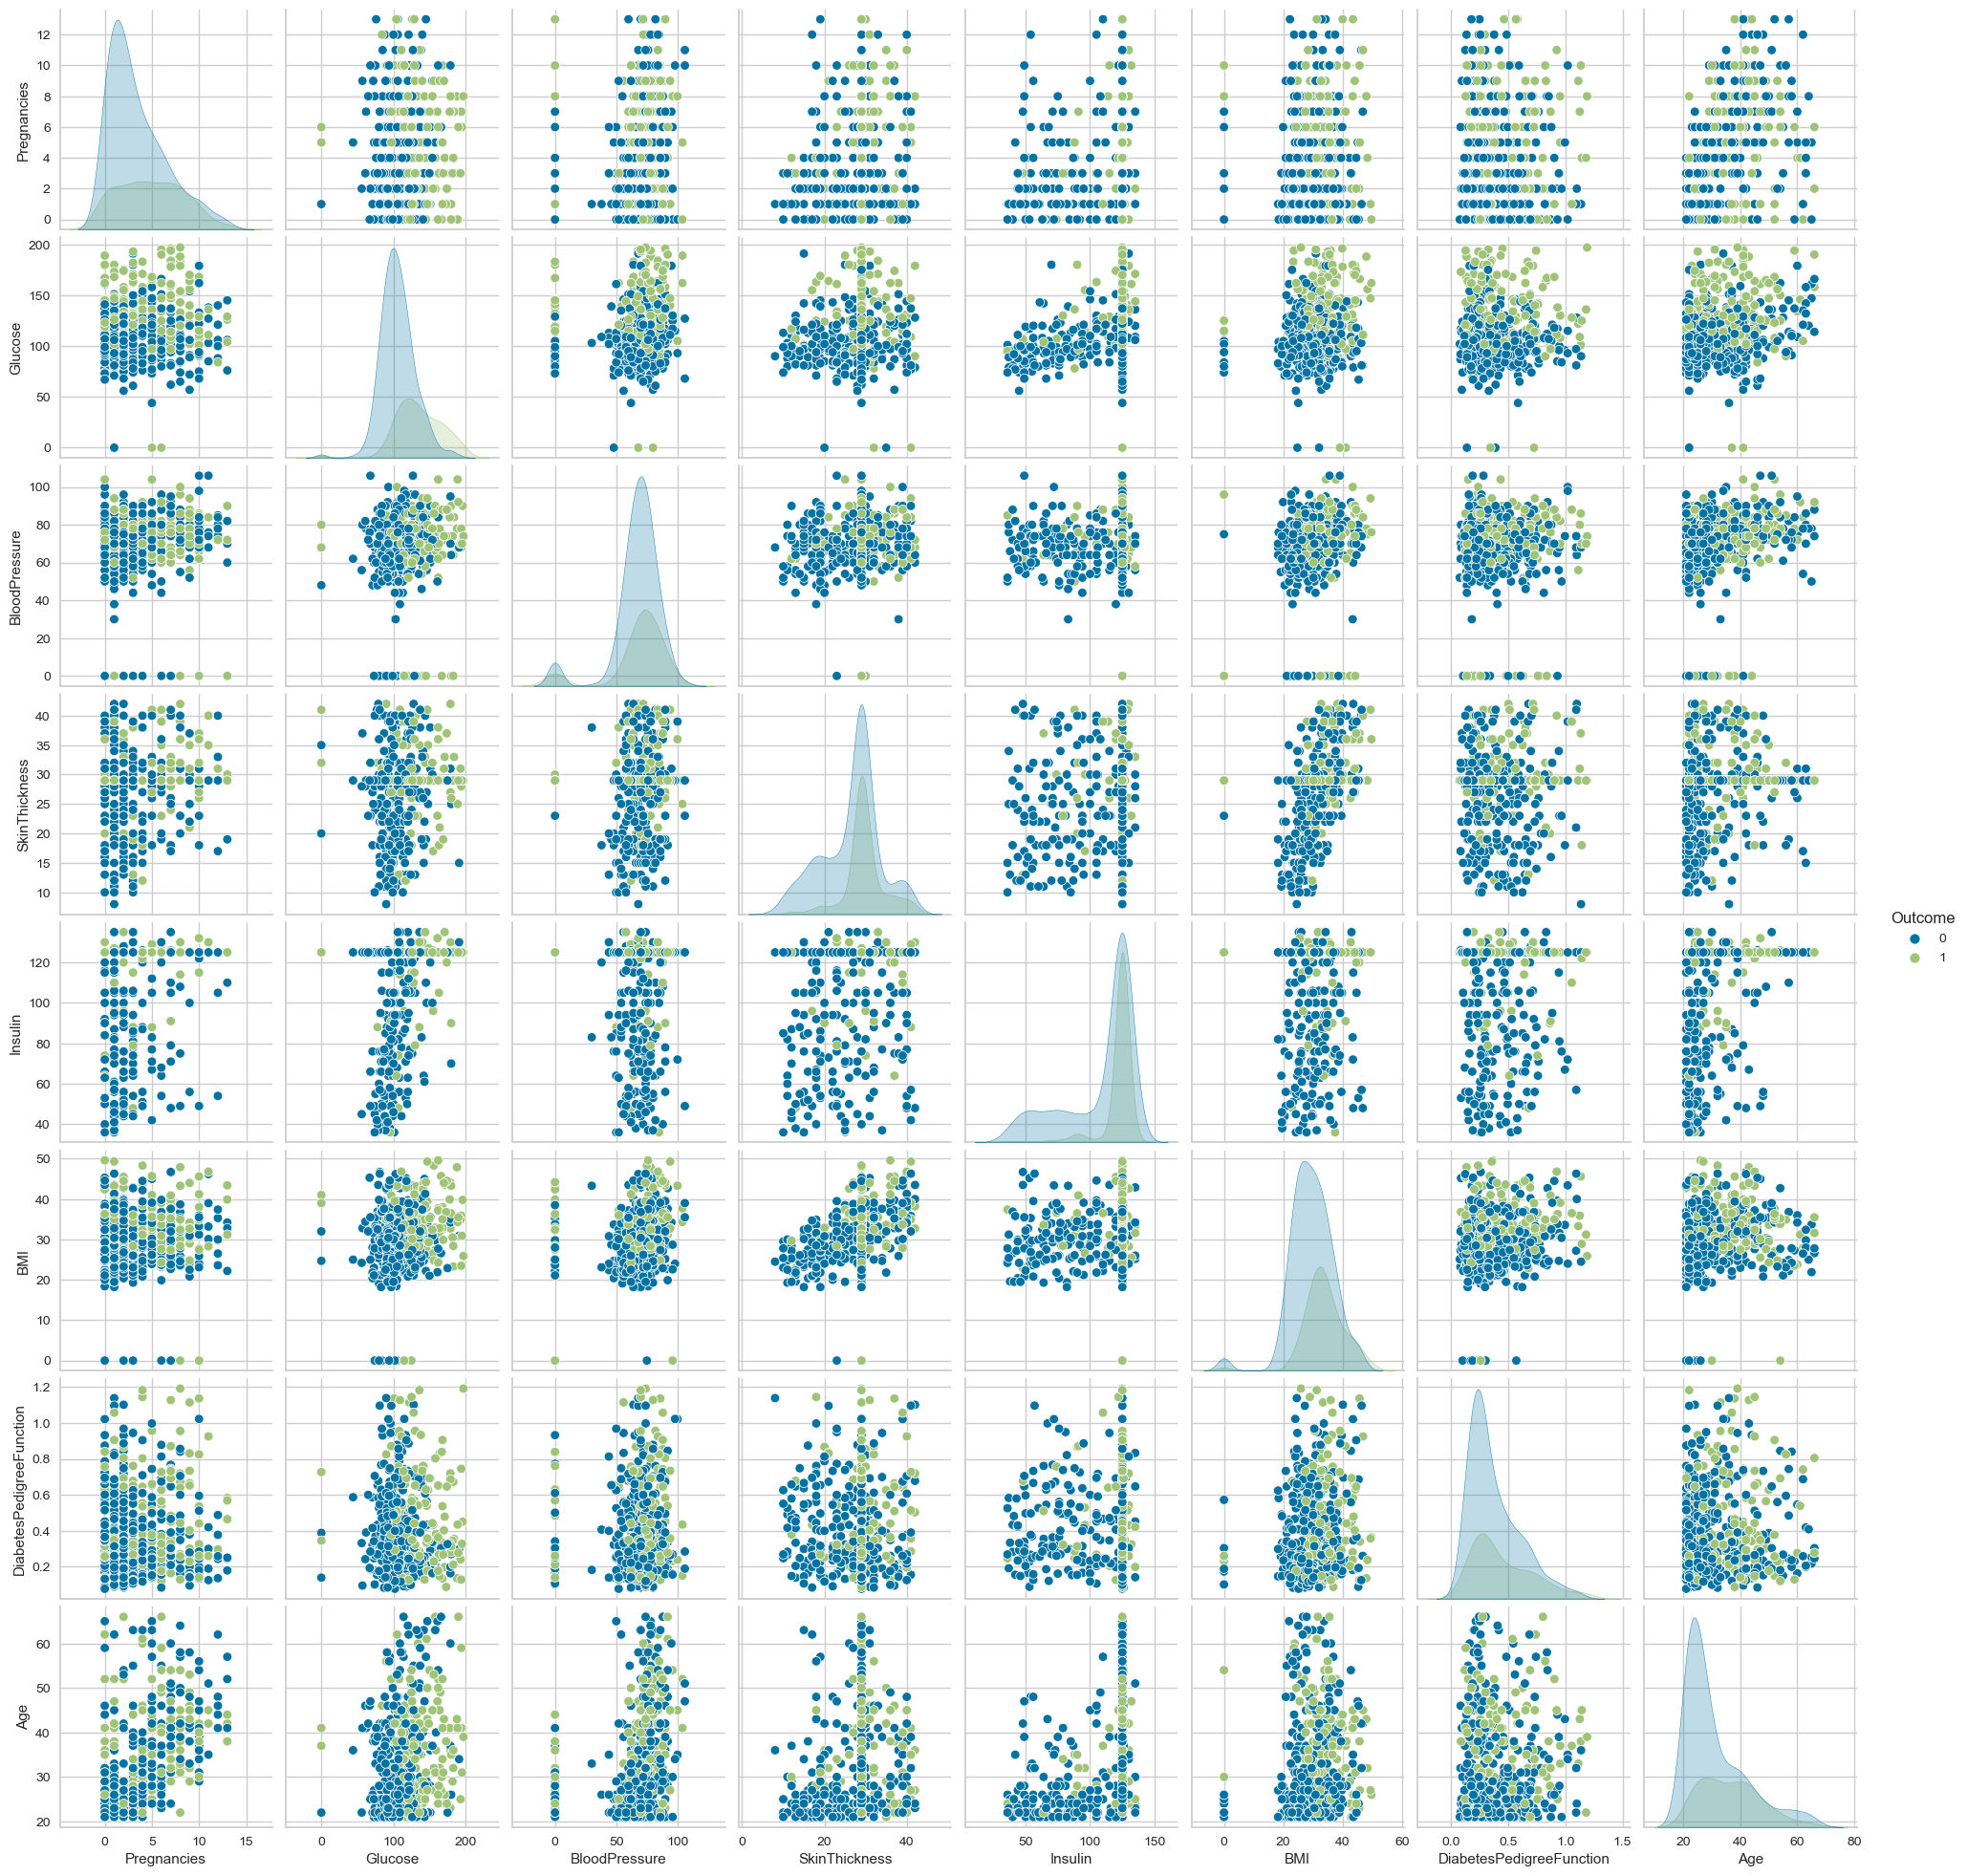

In [17]:
plt.figure(figsize=(15,10))
sns.pairplot(df, hue="Outcome")
plt.show()

In [18]:
#classification based on outcome column
#we need to split the data into a training set and a test set.
#This allows us to evaluate how well our model generalizes to unseen data.
#We'll use 80% of the data for training and 20% for testing.

X = df.drop("Outcome", axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)# Split the data into a training set and a test set
X_train.shape, X_test.shape

((419, 8), (105, 8))

#### Scaling the features 

In [19]:
scaler = StandardScaler() # Initialize the scaler
scaler.fit(X_train) # Fit the scaler to the training data
X_train_scaled = scaler.transform(X_train) # Transform the training and test sets
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((419, 8), (105, 8))

#### data_modeling 

In [20]:
def fit_and_evaluate(model):# Define a function to fit a model 
    model.fit(X_train_scaled, y_train)  # Fit the model
    train_preds = model.predict(X_train_scaled) # Make predictions on the training set and compute the accuracy
    train_acc = accuracy_score(y_train, train_preds)
    test_preds = model.predict(X_test_scaled) # Make predictions on the test set and compute the accuracy
    test_acc = accuracy_score(y_test, test_preds)
    return train_acc, test_acc


In [21]:
res=[]
models=[LogisticRegression(random_state=42),DecisionTreeClassifier(random_state=42),RandomForestClassifier(random_state=42),SVC(random_state=42)]
for i in models:
    res.append(fit_and_evaluate(i))
for mod,result in zip(models,res):
    print(f'train and test accuracy of {mod} respectively is: \n {result} \n \n')

train and test accuracy of LogisticRegression(random_state=42) respectively is: 
 (0.801909307875895, 0.8) 
 

train and test accuracy of DecisionTreeClassifier(random_state=42) respectively is: 
 (1.0, 0.6952380952380952) 
 

train and test accuracy of RandomForestClassifier(random_state=42) respectively is: 
 (1.0, 0.7142857142857143) 
 

train and test accuracy of SVC(random_state=42) respectively is: 
 (0.8448687350835322, 0.7714285714285715) 
 



In [22]:
from pycaret.classification import *

In [23]:
clf1 = setup(data = df, 
             target = 'Outcome',
             preprocess = False)

,Description,Value
0,Session id,4560
1,Target,Outcome
2,Target type,Binary
3,Original data shape,"(524, 9)"
4,Transformed data shape,"(524, 9)"
5,Transformed train set shape,"(366, 9)"
6,Transformed test set shape,"(158, 9)"
7,Numeric features,8


In [24]:
top5 = compare_models(sort='AUC',
                      n_select = 5,
                      exclude=['lightgbm','xgboost','dummy','svm','ridge','knn','dt','nb','qda']
                     )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7786,0.8341,0.4855,0.6584,0.5430,0.4072,0.4232,2.1120
lda,Linear Discriminant Analysis,0.7758,0.8212,0.4855,0.6640,0.5390,0.4021,0.4221,0.7400
catboost,CatBoost Classifier,0.7513,0.8196,0.4755,0.6037,0.5212,0.3591,0.3691,7.4750
rf,Random Forest Classifier,0.7677,0.8159,0.4855,0.6334,0.5364,0.3904,0.4018,1.0060
gbc,Gradient Boosting Classifier,0.7678,0.8140,0.5509,0.6173,0.5777,0.4192,0.4233,0.9130
et,Extra Trees Classifier,0.7703,0.8054,0.4282,0.6613,0.5049,0.3712,0.3911,1.0070
ada,Ada Boost Classifier,0.7270,0.7557,0.4873,0.5364,0.5066,0.3203,0.3228,0.8110


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

In [25]:
catboost = create_model('catboost')
rf = create_model('rf')
lr = create_model('lr')
lda = create_model('lda')

gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8919,0.9161,0.7273,0.8889,0.8000,0.7269,0.7338
1,0.7838,0.8147,0.4545,0.7143,0.5556,0.4219,0.4407
2,0.7568,0.8497,0.6364,0.5833,0.6087,0.4327,0.4336
3,0.7027,0.7797,0.5455,0.5000,0.5217,0.3066,0.3073
4,0.7297,0.6958,0.4545,0.5556,0.5000,0.3173,0.3203
5,0.6757,0.7797,0.3636,0.4444,0.4000,0.1808,0.1825
6,0.6944,0.8800,0.2727,0.5000,0.3529,0.1750,0.1888
7,0.7778,0.8615,0.3000,0.7500,0.4286,0.3208,0.3727
8,0.7222,0.7808,0.4000,0.5000,0.4444,0.2623,0.2652


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8919,0.8829,0.7273,0.8889,0.8000,0.7269,0.7338
1,0.7297,0.8217,0.3636,0.5714,0.4444,0.2773,0.2897
2,0.8378,0.8864,0.7273,0.7273,0.7273,0.6119,0.6119
3,0.6757,0.7517,0.4545,0.4545,0.4545,0.2238,0.2238
4,0.7297,0.6853,0.5455,0.5455,0.5455,0.3531,0.3531
5,0.7568,0.7780,0.4545,0.6250,0.5263,0.3681,0.3766
6,0.6944,0.8855,0.1818,0.5000,0.2667,0.1239,0.1492
7,0.7778,0.8481,0.3000,0.7500,0.4286,0.3208,0.3727
8,0.7500,0.7769,0.4000,0.5714,0.4706,0.3136,0.3221


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8919,0.8986,0.7273,0.8889,0.8000,0.7269,0.7338
1,0.8108,0.8601,0.4545,0.8333,0.5882,0.4789,0.5159
2,0.8649,0.9301,0.8182,0.7500,0.7826,0.6848,0.6862
3,0.7568,0.8182,0.5455,0.6000,0.5714,0.4022,0.4030
4,0.6757,0.6434,0.2727,0.4286,0.3333,0.1328,0.1387
5,0.7027,0.7867,0.2727,0.5000,0.3529,0.1811,0.1951
6,0.7500,0.8727,0.3636,0.6667,0.4706,0.3250,0.3506
7,0.7778,0.9154,0.3000,0.7500,0.4286,0.3208,0.3727
8,0.7222,0.7538,0.3000,0.5000,0.3750,0.2105,0.2219


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8649,0.8531,0.7273,0.8000,0.7619,0.6679,0.6693
1,0.8108,0.8601,0.4545,0.8333,0.5882,0.4789,0.5159
2,0.8649,0.9091,0.8182,0.7500,0.7826,0.6848,0.6862
3,0.7568,0.8252,0.5455,0.6000,0.5714,0.4022,0.4030
4,0.6486,0.6643,0.2727,0.3750,0.3158,0.0873,0.0893
5,0.7568,0.7622,0.2727,0.7500,0.4000,0.2869,0.3448
6,0.7500,0.8764,0.3636,0.6667,0.4706,0.3250,0.3506
7,0.7778,0.8692,0.3000,0.7500,0.4286,0.3208,0.3727
8,0.7222,0.7385,0.3000,0.5000,0.3750,0.2105,0.2219


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8919,0.9301,0.7273,0.8889,0.8000,0.7269,0.7338
1,0.7027,0.7028,0.4545,0.5000,0.4762,0.2693,0.2699
2,0.7838,0.8217,0.6364,0.6364,0.6364,0.4825,0.4825
3,0.7568,0.8112,0.6364,0.5833,0.6087,0.4327,0.4336
4,0.7838,0.7587,0.6364,0.6364,0.6364,0.4825,0.4825
5,0.6757,0.7622,0.3636,0.4444,0.4000,0.1808,0.1825
6,0.7500,0.8727,0.4545,0.6250,0.5263,0.3622,0.3707
7,0.7778,0.8269,0.4000,0.6667,0.5000,0.3684,0.3883
8,0.7500,0.8038,0.5000,0.5556,0.5263,0.3571,0.3581


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

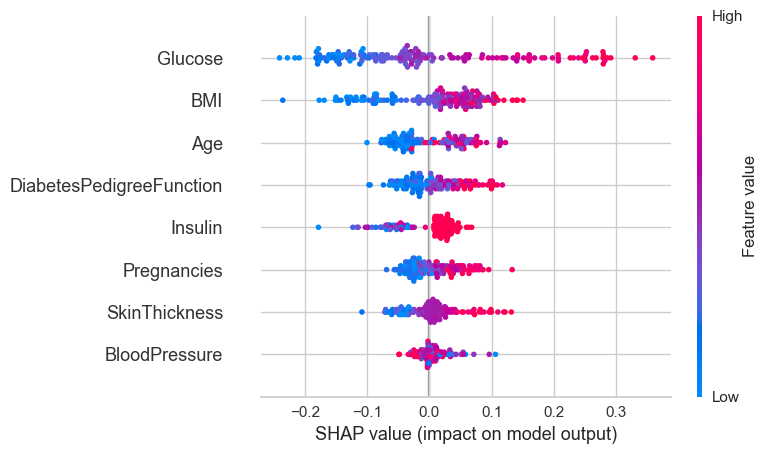

In [26]:
interpret_model(rf)

#### As expected, glucose is used as the most important feature.
#####  BloodPressure have the low importance.

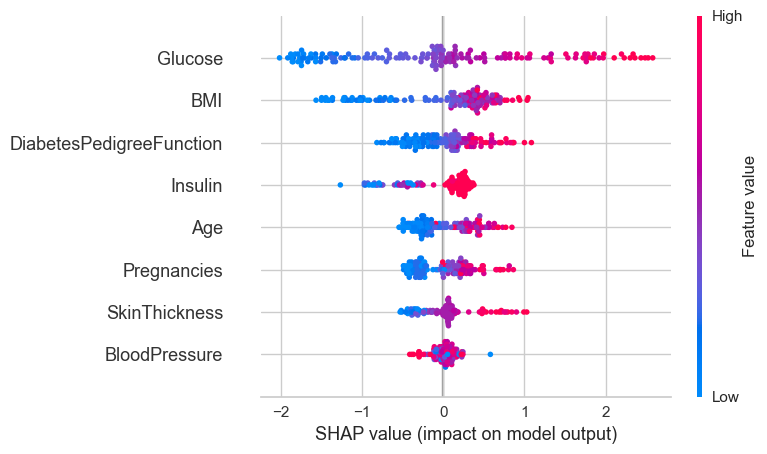

In [27]:
interpret_model(catboost)

#### Tunning hyperparameter

In [28]:
tuned_catboost = tune_model(catboost, optimize = 'AUC')
tuned_rf = tune_model(rf, optimize = 'AUC')
tuned_lr = tune_model(lr, optimize = 'AUC')
tuned_lda = tune_model(lda, optimize = 'AUC')
tuned_gbc = tune_model(gbc, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8919,0.9161,0.7273,0.8889,0.8000,0.7269,0.7338
1,0.8108,0.7832,0.4545,0.8333,0.5882,0.4789,0.5159
2,0.7838,0.8601,0.5455,0.6667,0.6000,0.4539,0.4582
3,0.7027,0.7972,0.3636,0.5000,0.4211,0.2277,0.2329
4,0.7568,0.7413,0.4545,0.6250,0.5263,0.3681,0.3766
5,0.6757,0.7867,0.3636,0.4444,0.4000,0.1808,0.1825
6,0.7222,0.9018,0.3636,0.5714,0.4444,0.2713,0.2836
7,0.8056,0.8385,0.4000,0.8000,0.5333,0.4273,0.4682
8,0.6944,0.7577,0.3000,0.4286,0.3529,0.1610,0.1654


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8919,0.9231,0.7273,0.8889,0.8000,0.7269,0.7338
1,0.8108,0.8007,0.4545,0.8333,0.5882,0.4789,0.5159
2,0.7838,0.8706,0.6364,0.6364,0.6364,0.4825,0.4825
3,0.6757,0.8077,0.4545,0.4545,0.4545,0.2238,0.2238
4,0.6757,0.6818,0.4545,0.4545,0.4545,0.2238,0.2238
5,0.7838,0.8217,0.5455,0.6667,0.6000,0.4539,0.4582
6,0.7500,0.9127,0.3636,0.6667,0.4706,0.3250,0.3506
7,0.7778,0.8308,0.3000,0.7500,0.4286,0.3208,0.3727
8,0.6944,0.7731,0.3000,0.4286,0.3529,0.1610,0.1654


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8919,0.8951,0.7273,0.8889,0.8000,0.7269,0.7338
1,0.8108,0.8601,0.4545,0.8333,0.5882,0.4789,0.5159
2,0.8919,0.9301,0.9091,0.7692,0.8333,0.7542,0.7599
3,0.7568,0.8147,0.5455,0.6000,0.5714,0.4022,0.4030
4,0.7027,0.6399,0.2727,0.5000,0.3529,0.1811,0.1951
5,0.7027,0.7867,0.2727,0.5000,0.3529,0.1811,0.1951
6,0.7500,0.8764,0.3636,0.6667,0.4706,0.3250,0.3506
7,0.7778,0.9154,0.3000,0.7500,0.4286,0.3208,0.3727
8,0.7222,0.7538,0.3000,0.5000,0.3750,0.2105,0.2219


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8649,0.9091,0.6364,0.8750,0.7368,0.6490,0.6638
1,0.7838,0.8636,0.3636,0.8000,0.5000,0.3859,0.4348
2,0.8378,0.9301,0.7273,0.7273,0.7273,0.6119,0.6119
3,0.7838,0.8322,0.6364,0.6364,0.6364,0.4825,0.4825
4,0.6486,0.6084,0.2727,0.3750,0.3158,0.0873,0.0893
5,0.7027,0.7727,0.2727,0.5000,0.3529,0.1811,0.1951
6,0.8056,0.8873,0.4545,0.8333,0.5882,0.4750,0.5124
7,0.7778,0.8885,0.3000,0.7500,0.4286,0.3208,0.3727
8,0.6944,0.7769,0.3000,0.4286,0.3529,0.1610,0.1654


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7027,0.9161,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7027,0.8182,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7027,0.8531,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7027,0.7937,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7027,0.7098,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7027,0.7867,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6944,0.8945,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7222,0.8846,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7222,0.8038,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [29]:
stack_model = stack_models(estimator_list = top5, meta_model = top5[0],optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8919,0.8811,0.7273,0.8889,0.8000,0.7269,0.7338
1,0.8108,0.8531,0.4545,0.8333,0.5882,0.4789,0.5159
2,0.8108,0.9161,0.6364,0.7000,0.6667,0.5350,0.5362
3,0.7568,0.8182,0.5455,0.6000,0.5714,0.4022,0.4030
4,0.6757,0.6154,0.1818,0.4000,0.2500,0.0788,0.0888
5,0.7027,0.7762,0.2727,0.5000,0.3529,0.1811,0.1951
6,0.7500,0.8764,0.3636,0.6667,0.4706,0.3250,0.3506
7,0.7778,0.9077,0.3000,0.7500,0.4286,0.3208,0.3727
8,0.7222,0.7385,0.2000,0.5000,0.2857,0.1509,0.1754


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [31]:
#prediction
pred = stack_model.predict(X_test)
#accuracy
accuracy = accuracy_score(y_test, pred)
print('Accuracy:', accuracy)
print('Classification Report:')
print(classification_report(y_test, pred))
roc_auc = roc_auc_score(y_test, pred)
print('ROC-AUC:', roc_auc)
confusion_stack = confusion_matrix(y_test, pred)
print('Confusion Matrix:\n', confusion_stack)

Accuracy: 0.780952380952381
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        69
           1       0.74      0.56      0.63        36

    accuracy                           0.78       105
   macro avg       0.77      0.73      0.74       105
weighted avg       0.78      0.78      0.77       105

ROC-AUC: 0.7270531400966184
Confusion Matrix:
 [[62  7]
 [16 20]]


# soft voting

In [32]:
blend_soft = blend_models(estimator_list = top5, optimize = 'AUC',method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8919,0.8986,0.7273,0.8889,0.8000,0.7269,0.7338
1,0.7838,0.8217,0.4545,0.7143,0.5556,0.4219,0.4407
2,0.7838,0.8951,0.6364,0.6364,0.6364,0.4825,0.4825
3,0.7297,0.8112,0.6364,0.5385,0.5833,0.3854,0.3883
4,0.7027,0.6923,0.4545,0.5000,0.4762,0.2693,0.2699
5,0.7297,0.7727,0.3636,0.5714,0.4444,0.2773,0.2897
6,0.6944,0.8800,0.1818,0.5000,0.2667,0.1239,0.1492
7,0.7778,0.8769,0.3000,0.7500,0.4286,0.3208,0.3727
8,0.6944,0.7885,0.3000,0.4286,0.3529,0.1610,0.1654


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

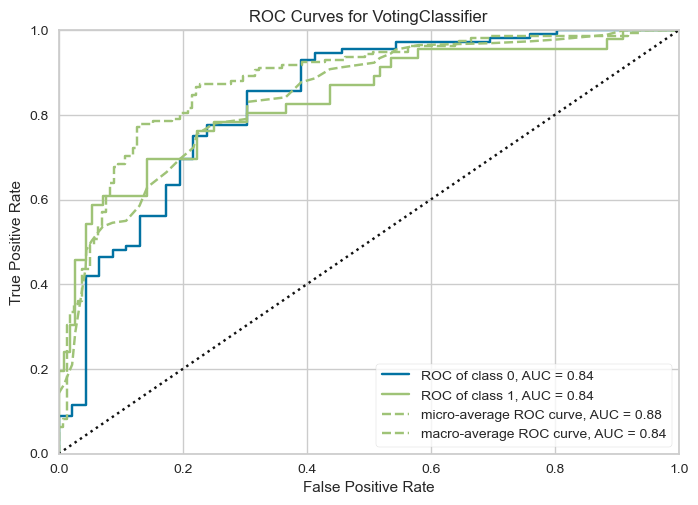

In [34]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot = 'auc')

In [36]:
#prediction
pred = blend_soft.predict(X_test)
#accuracy
accuracy = accuracy_score(y_test, pred)
print('Accuracy:', accuracy)
print('Classification Report:')
print(classification_report(y_test, pred))
roc_auc = roc_auc_score(y_test, pred)
print('ROC-AUC:', roc_auc)
confusion_stack = confusion_matrix(y_test, pred)
print('Confusion Matrix:\n', confusion_stack)

Accuracy: 0.9428571428571428
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        69
           1       0.94      0.89      0.91        36

    accuracy                           0.94       105
   macro avg       0.94      0.93      0.94       105
weighted avg       0.94      0.94      0.94       105

ROC-AUC: 0.929951690821256
Confusion Matrix:
 [[67  2]
 [ 4 32]]


# hard voting

In [37]:
blend_hard = blend_models(estimator_list = top5, optimize = 'AUC',method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8919,0.0000,0.7273,0.8889,0.8000,0.7269,0.7338
1,0.7838,0.0000,0.4545,0.7143,0.5556,0.4219,0.4407
2,0.8108,0.0000,0.6364,0.7000,0.6667,0.5350,0.5362
3,0.7568,0.0000,0.6364,0.5833,0.6087,0.4327,0.4336
4,0.7027,0.0000,0.4545,0.5000,0.4762,0.2693,0.2699
5,0.7568,0.0000,0.3636,0.6667,0.4706,0.3300,0.3555
6,0.6944,0.0000,0.1818,0.5000,0.2667,0.1239,0.1492
7,0.7778,0.0000,0.3000,0.7500,0.4286,0.3208,0.3727
8,0.7500,0.0000,0.4000,0.5714,0.4706,0.3136,0.3221


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [39]:
#prediction
pred = blend_hard.predict(X_test)
#accuracy
accuracy = accuracy_score(y_test, pred)
print('Accuracy:', accuracy)
print('Classification Report:')
print(classification_report(y_test, pred))
roc_auc = roc_auc_score(y_test, pred)
print('ROC-AUC:', roc_auc)
confusion_stack = confusion_matrix(y_test, pred)
print('Confusion Matrix:\n', confusion_stack)

Accuracy: 0.9333333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        69
           1       0.91      0.89      0.90        36

    accuracy                           0.93       105
   macro avg       0.93      0.92      0.93       105
weighted avg       0.93      0.93      0.93       105

ROC-AUC: 0.9227053140096618
Confusion Matrix:
 [[66  3]
 [ 4 32]]


# Conclusion
After EDA and preprocessing, three ensamble models were run and the performance was verified with the validation dataset. Ensamble using soft and hard voting gave the best result in solving this problem, but different results may come out depending on preprocessing and selection of base models and hyperparameter settings